# RDBMS - SQL 3

## Topics
* Views
* Integrity Constraints
* Stored Functions and Stored Procedures
* Triggers
* Database Security
---

## For this chapter, we will be using the Schema below

### University Schema

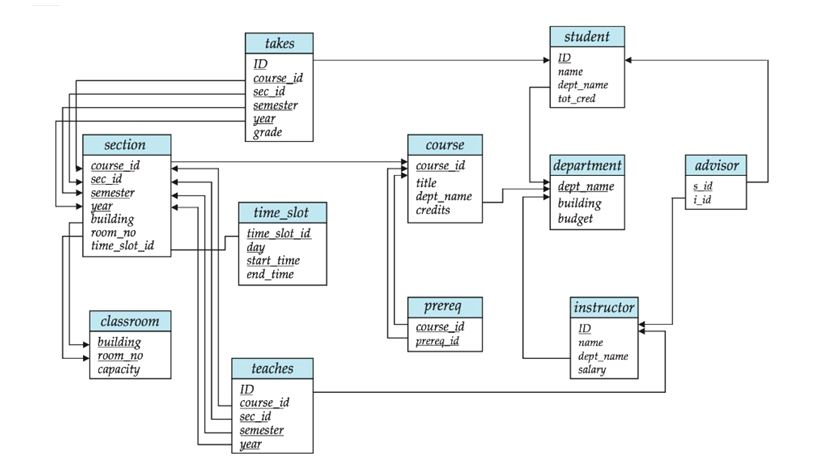

**Classroom**(<u>building</u>, <u>room_number</u>, capacity) <br>
**Department**(<u>dept_name</u>, building, budget) <br>
**Course**(<u>course_id</u>, title, dept_name, credits) <br>
**Instructor**(<u>ID</u>, name, dept_name, salary) <br>
**Section**(<u>course_id</u>, <u>sec_id</u>, <u>semester</u>, <u>year</u>, building, room_number, time_slot_id) <br>
**Teaches**(<u>ID</u>, <u>course_id</u>, <u>sec_id</u>, <u>semester</u>, <u>year</u>) <br>
**Student**(<u>ID</u>, name, dept_name, tot_cred) <br>
**Takes**(<u>ID</u>, <u>course_id</u>, <u>sec_id</u>, <u>semester</u>, <u>year</u>, grade) <br>
**Advisors**(<u>s_ID</u>, <u>i_ID</u>) <br>
**Time_slot**(<u>time_slot_id</u>, <u>day</u>, <u>start_time</u>, end_time) <br>
**Prereq**(<u>course_id</u>, <u>prereq_id</u>) <br>

---

## Views

Views are a special version of tables in SQL. It can be used by Database Administrators and database users to create a proxy over the the original table (imagine a re-sizable window over the original table).

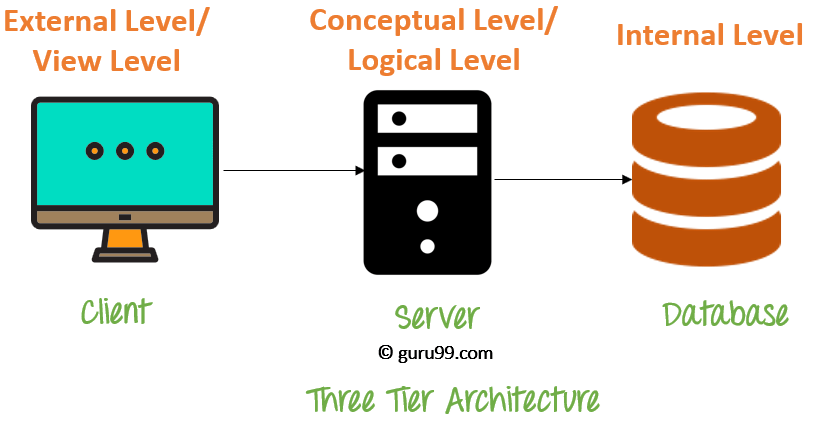

Generally DBMS, have 3 main levels of data abstraction:
1. Internal Level: Actual PHYSICAL storage structure and access paths.
2. Conceptual or Logical Level: Structure and constraints for the entire database
3. External or View level: Describes various user views

#### Brief Overview

**Internal Level**
* the lowest level of data abstraction
* literary the actual storage of the data on the disk in the form of records
* tells us what data is stored in the database and how
* views a physical device as a collection of physical pages

**Conceptual level (what we have been learning thus far and more)**
* defines all database entities, their attributes and their relationships
* security and integrity information
* the data available to a user must be contained in or derivable from the physical level

**External level (What we will be learning in this section)**
* only related to the data which is viewed by specific end users
* includes some external schemas which is nearest to the user
 * External schemas describes the segment of the database which is needed for a certain user group and hides the remaining details from the database from the specific user group

Now that we have a brief understanding of the 3 levels let's give some scenarios on why we would require these external schemas (views).
* imagine the admin clerk who needs to know an employee's information such as employee ID, name and department but they are not allowed to know the employee's salary. (this is a security concern)
* students of a university would want to know the courses being offered in the summer semester but they are not allowed to view courses of the other semesters. (information hiding)

Instead of using pure SQL to solve those queries, we can define a **view** for it. Views are "virtual relations" based on the conceptual schema.

### View Creation and Manipulation

#### Creating views
We can create a view using the `CREATE VIEW` command like so:
```sql
CREATE VIEW v AS <query expression>;
```

**Example**
```sql
/* Creating the view for the admin clerk to show only the authorized employee's information. */
CREATE VIEW faculty AS (SELECT ID, name, dept_name FROM instructor);

/* creating a view of all students taking subject offered by the Comp. Sci. department*/
CREATE VIEW studentsTakingCompSciSubject AS 
    (SELECT * FROM student WHERE ID IN 
        (SELECT takes.ID FROM takes JOIN course ON takes.course_id=course.course_id
            AND course.dept_name = "Comp. Sci."));
```
Notice how creating the view is just your regular SQL statement encased in the `CREATE VIEW` command. **Note** that we will not be able to "see" the created view. The DBMS stores the query expression associated with the view relation thus if we want to see the view output, we use the `SELECT` statement on the view. 

**Note** that *views* are like a virtual table composed of fields from one or more tables in the database; it can also include fields from other views. It **does not** store data on its own. In fact, the only information about a view that is stored in the database is its structure.

**Example: Viewing the view of `studentsTakingCompSciSubject`**
```sql 
SELECT * FROM studentsTakingCompSciSubject;
```

**Views from Queries using Aggregation Functions**<br>
We can even construct views from statements with aggregated outputs.

**Example: Creating a view to show the stats of each faculty's average salaries**
```sql
CREATE VIEW statsFacultySalary AS
    (SELECT i.dept_name, AVG(salary), COUNT(i.ID) 
     FROM instructor AS i, department AS d
     WHERE i.dept_name = d.dept_name
     GROUP BY d.dept_name);
```

#### Views Manipulation

Creating a view is liken to creating a smaller subset of the original database and because of that, we can manipulate the "data" in the views **almost similarly** to the CRUD statements that we have learnt.

**Querying Views**<br>
Let's say that we want a list of students who have been taking Comp. Sci. courses that have more than 55 total credits. If we where to do that using the normal way, we would have constructed a SQL statement like 
```sql
SELECT * FROM 
    ((SELECT DISTINCT takes.ID FROM takes JOIN course ON takes.course_id=course.course_id
        AND course.dept_name = "Comp. Sci.") o
LEFT JOIN student ON o.ID = student.ID)
WHERE tot_cred > 55;
```

Breaking that SQL statement down, we have (starting from inner most query)
```sql
/* Gets all unique student IDs that have taken Comp. Sci. courses */
SELECT DISTINCT takes.ID FROM takes JOIN course ON takes.course_id=course.course_id
    AND course.dept_name = "Comp. Sci."

/* Left Join the result with the student table */
((SELECT DISTINCT takes.ID FROM takes JOIN course ON takes.course_id=course.course_id
    AND course.dept_name = "Comp. Sci.") o
LEFT JOIN student ON o.ID = student.ID)
```

Output of the `LEFT JOIN` result with the `student` table:<br>
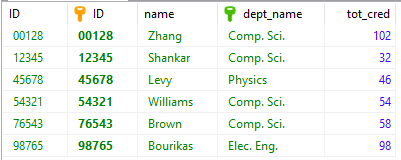

Then implementing the predicate of more than 55 total credits to get the following output:<br>
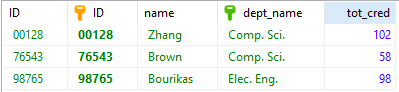

Let's try using the created view `studentsTakingCompSciSubject` from before. The output of that is the same as the output `LEFT JOIN` statement. We can then add the predicate to the view like 
```sql
SELECT * FROM studentsTakingCompSciSubject WHERE tot_cred > 55;
```

Aggregate functions can also be applied to the attributes of the views like
```sql
SELECT AVG(tot_cred) FROM studentsTakingCompSciSubject WHERE tot_cred > 55;
```

**Updating Views**<br>
Views are generally a useful tool for queries but they do present problems when we want to do operations like updating, insertions or deletions with the data in the view relations.

Take for example the `faculty` created view:
```sql
CREATE VIEW faculty AS (SELECT ID, name, dept_name FROM instructor);
```
the view only shows a smaller subset of all the columns from the `instructor` table. If we were to insert a new `instructor` record into the table, we would require the *salary* information. There are 2 reasonable approaches to dealing with this:
* reject the insertion and return an error message
* insert into the instructor table a new record with the values `('58456', 'Gean', 'Music', NULL)` 

The second option is still possible **if** the `salary` attribute allows `NULL` values. However, what about views that are derived from `JOIN`s (multiple table relationships) or aggregation functions? They would be impossible to update therefore these modifications are generally not permitted. **Different database systems specify different conditions under which they permit updates on view relations therefore you will need to consult their manuals.**

In general, an SQL view is said to be *updatable* **if** the following conditions are all satisfied by the query defining
the view:
* The `FROM` clause has **only one** database relation.
* The `SELECT` clause contains only attribute names of the relation and **do not** have any arithmetic expressions, aggregates or distinct specification.
* Any attribute **not listed** in the `SELECT` clause **can be set to `NULL`**; that is, it does not have a `NOT NULL` constraint and is not part of a primary key.
* The query does not have a `GROUP BY` or `HAVING` clause.

**Deleting Views**<br>
Since views are stored by the DBMS, it would be helpful to know how many views we have for a particular database then proceed to delete those that are not required. Bear in mind that if a views are **unique** therefore if we want to update a view relation, we would have to delete the view it is associated with then recreate the view again with the updated query expression.

Syntax for deleting a view:
```sql
DROP VIEW <view_name>
```

**Example: Showing current views then deleting one of the views**
```sql
/* List the all views in the database */
SELECT 
  TABLE_SCHEMA,
  TABLE_NAME
FROM INFORMATION_SCHEMA.VIEWS;

/* deleting a view*/
DROP VIEW studentsTakingCompSciSubject;
```

#### Reasons why views are needed

1. **They can be used to work with data from multiple tables simultaneously.**<br>
 A view provides the mechanism that allows you to work with data from two or more related tables simultaneously.

2. **They reflect the most current information.**<br>
 Because the RDBMS rebuilds and repopulates the view every time you access it, the information displayed by the view exhibits the most recent changes to the data in its base tables.

3. **Views can be customized to the specific needs of an individual or group of individuals.**<br>
 A view can build a view to suit any set of requirements, such as providing the data for a particular report or providing a means of examining specific information that is common to several departments within an organization.
 
4. **Views can be used to help enforce data integrity.**<br>
 Through a *validation view* that works in the same manner as a validation table with the purpose to provide a valid range of values for a given field in the database. (out of scope)

5. **View can be used for security or confidentiality purposes.**<br>
 By determining which data is available to a particular user or group of users by defining a view on select fields from the view’s base tables.

---
## Integrity Constraints

Whenever authorized users make changes to the database, there should be check involved to prevent loss of data consistency. What does data consistency mean? 

Let's see some examples of data inconsistencies:
* instructor name is `NULL`
* 2 students having the same student ID
* department having a budget less than 0.00

We can breakdown the steps used by the DBMS to keep the integrity of the data into 4 steps:
1. the database administrator defines the integrity constraints during the database creation stage (DDL)
2. a request is made by the database user to update or insert data
3. DBMS validates the request based on the defined constraints
4. the request is either allowed to go through or rejected.

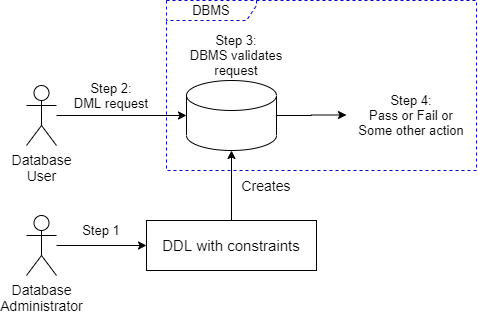

Each of those 4 steps can also be identified as 4 components of integrity constraints:
* Object - is the attributes/columns of the relation/table
* Predicate condition - conditions applied to the attributes 
* Trigger - insert/update statements
* Response - acceptance or rejection of the modification requests

There are also 2 types of constraints: 
* **static** - are constraints that are defined during the creation of the databases. eg: primary keys
* **dynamic** - also called **triggers** are constraints that are triggered as a side effect of a modification request (will be covered in the next section on Triggers).

### Static Integrity Constraints

We have seen some of these constraints before:
* Entity integrity - Primary key
* Referential integrity - Foreign key
* User defined integrity (new)

#### Recap - Creating Tables

**Primary Keys**<br>
Remember the `CREATE` statements from the bunch of CRUD statements that we have learnt?

```sql
CREATE TABLE dept(dID CHAR(2) NOT NULL, dName CHAR(20), dean CHAR(50),
                 PRIMARY KEY(dID));
```
We placed a `PRIMARY KEY` constraint on the attribute `dID` to "tell" the DBMS that this column uniquely identifies each tuple in the the database. 

**Foreign Keys**<br>
These keys are used to link one table to another. This particular constraint also has referencing options which tells the DBMS what kind of action to take when the referenced values in the parent table (is the referenced table) are deleted or updated.

```sql
CREATE TABLE student(sID CHAR(8) NOT NULL, sName CHAR(50) NOT NULL,
                    gender CHAR(1), age INT, dID CHAR(2), grade CHAR(2),
                    PRIMARY KEY(sID),
                    FOREIGN KEY(dID) 
                     REFERENCES dept(dID) ON DELETE CASCADE);
```

For MariaDB the options are:
* `RESTRICT` - The delete/update operation is not performed. The statement terminates with a 1451 error (SQLSTATE '2300'). **Default setting**
* `NO ACTION` - Same as `RESTRICT`.
* `CASCADE` - The delete/update operation is performed in both tables.
* `SET NULL` - The update or delete goes ahead in the parent table, and the corresponding foreign key fields in the child table are set to `NULL`. (They must not be defined as `NOT NULL` for this to succeed).
* `SET DEFAULT` - This option is implemented only for the legacy PBXT storage engine, which is disabled by default and no longer maintained. It sets the child table's foreign key fields to their DEFAULT values when the referenced parent table key entries are updated or deleted.

**Not Null**<br>
This constraint can be added to any table column to prohibit any `NULL` values in columns that could be inappropriate like the name of a student or instructor. Primary key constraints **by default** already have the `NOT NULL` constraint included therefore it is not needed to explicitly declared it.

**Unique**<br>
This constraint will ensure the value/s in a column or a set of column/s are unique. These are generally applied to columns that store country codes, email addresses, etc. There are 2 ways to add the `UNIQUE` constraint during table creation.

```sql
/* method 1*/
CREATE TABLE Customer (
  ID TINYINT(3) UNSIGNED NOT NULL,
  First_Name VARCHAR(25) NOT NULL,
  Last_Name VARCHAR(25) NOT NULL,
  Email VARCHAR(50) NOT NULL,
  PRIMARY KEY (ID),
  UNIQUE KEY (Email));

/* method 2*/
CREATE TABLE Customer (
  ID TINYINT(3) UNSIGNED NOT NULL,
  First_Name VARCHAR(25) NOT NULL,
  Last_Name VARCHAR(25) NOT NULL,
  Email VARCHAR(50) NOT NULL UNIQUE,
  PRIMARY KEY (ID);
```

#### User defined constraints

This is used to enforce a check on the value/s in a column or a group of columns for the right value/s before inserting or updating the tuple. This is done via the `CHECK` constraint.

**Example**
```sql
CREATE TABLE classes(
    class_id INT AUTO_INCREMENT,
    class_name VARCHAR(255) NOT NULL,
    student_count INT 
    CHECK(student_count >0),
    PRIMARK KEY(class_id));
```
In the above SQL statement, the check placed on the `student_count` column ensures that the number of students for each class record must be more than 0. 

The general syntax for the `CHECK` constraint is:
```sql
<column_name> <datatype> CHECK(<expression>)
```
where the `expression` always evaluates to a Boolean result.

We can also give a name to the `CHECK` constraint via the syntax:
```sql
CONSTRAINT <constraint_name> CHECK (<expression>)
```

This constraint can also be applied to multiple columns of the same table. 
```sql
CREATE TABLE course(
    cID char(3) PRIMARY KEY,
    cName char(12),
    hours int,
    credit float,
    iID CHAR(5),
CONSTRAINT ctcredit CHECK(credit>=0 and credit<=5),
CONSTRAINT ctcc CHECK(hours/credit > 10),
FOREIGN KEY (iID) REFERENCES instructor(iID) ON DELETE CASCADE );
```
**Note** that the `CHECK` constraints are located at the end of all table columns!<br>
**`CHECK` constraint on multiple tables is not supported in MariaDB.**

### Adding or removing a constraint from an existing table

If we forget to add the constraint, we can use the `ALTER TABLE` statement to add the constraint to the table. 
```sql
/* adding primary key */
ALTER TABLE <table_name> PRIMARY KEY (<column_name_1>, ..., <column_name_n>);

/* adding foreign key */
ALTER TABLE <table_name> ADD FOREIGN KEY <constraint_name> (<column_name_1>, ..., <column_name_n>) 
    REFERENCES <table_name>(<column_name_1>, ..., <column_name_n>) ON DELETE CASCADE ON UPDATE CASCADE;

/* adding check constraint */
ALTER TABLE <table_nam> ADD CONSTRAINT <check_constraint_name> CHECK(<expression>);

/* adding unique constraint*/
ALTER TABLE <table_nam> ADD CONSTRAINT <unique_constraint_name> UNIQUE(<column_name_1>, ..., <column_name_n>);

/* adding not null constraint*/
ALTER TABLE <table_nam> MODIFY <column_name> <column_datatype> NOT NULL;
```
And we can remove the primary key constraint via the same `ALTER TABLE` statement but with the `DROP` keywords. <br>
**Note** that for primary keys, it will remove all primary keys from the given table
```sql
/* removing primary key */
ALTER TABLE <table_name> DROP PRIMARY KEY;

/* removing foreign key */
ALTER TABLE <table_name> DROP FOREIGN KEY <foreign_key_name>;
ALTER TABLE <table_name> DROP INDEX <foreign_key_name>;

/* removing check constraint */
ALTER TABLE <table_name> DROP CONSTRAINT <check_constraint_name>;

/* removing unique constraint */
ALTER TABLE <table_name> DROP INDEX <unique_constraint_name>;

/* removing not null constraint*/
ALTER TABLE <table_nam> MODIFY <column_name> <column_datatype>;
```

### Brief Introduction to Indexing

From the `ALTER` statements in the previous section, we can see that the `FOREIGN KEY` requires 2 `ALTER` statements to remove the constraint (one of them being an `INDEX`. So what are indexes? Indexes are data structures placed on an attribute of a table that allows the database system to find those records in the table (that have a specified value for that attribute) efficiently. Indexes are not part of the logical schema but they are used in combination with the physical schema (aka how the data is stored physically).

**Pros** <br>
* Speeds up `SELECT` queries when the attribute in the `WHERE` clause has an index.
* no duplications, `PRIMARY KEY` constraints are also indexes and they are unique.
* helps with sorting and grouping results

**Cons** <br>
* Slows down `INSERT`, `UPDATE` and `DELETE` statements because the indexes have to be updated after each statement is processed. However, it will speed up `UPDATE` statements if the attribute in the `WHERE` clause has an index. 
* redundant data structures

To create an `INDEX`, we use the `CREATE INDEX` statement:
``` sql
CREATE INDEX <index_name> ON <table_name>(<attribute_name>);
```
and to remove the index, the `ALTER` statement is used.

There is **no hard and fast rule** on *how to select the best attributes for indexing* but there are general strategies:
1. Determine the workload of the database, as in "is it used more for searching and retrievals or for mostly storage?". 
2. Index attributes that are used heavily in queries (aka queries that are executed multiple times every few hours or a day), especially attributes used in `JOIN` operations in the predicates (the `WHERE` clause part of the SQL statements). 
3. The `GROUP BY` and `ORDER BY` clauses tend to invoke some sorting algorithm which can cause performance slowdowns. Indexing the attributes will help the relational optimizer avoid using the sorting algorithm.
4. If certain group of data can be used to form a unique superkey (composite index), it helps with performance.

**Key takeaway point is:**<br>
You do not need to limit the number of indexes for your database but you should create enough of it to reach the right balance to support the performance of your database queries.

---
## Stored Functions and Stored Procedures

Thus far, we have seen and used functions (eg: aggregation functions) that were built into the SQL language. But what happens if we want to create our own user-defined functions and procedures, store them in the database, and then invoke them from SQL statements?

Functions are particularly useful with specialized data types. Procedures and functions allow "business logic" to be stored in the database and executed from SQL statements. 

**IMPORTANT NOTE:** The general syntax for function and stored procedures is **slightly** different for every DBMS. The examples in this section pertain to the **MariaDB only**. But the concepts taught are applicable across implementations.

### Stored Functions
Let's start with an example of a "business logic":
> Universities generally have many rules about how many courses a student can take in a given semester, the minimum number of
courses a full-time instructor must teach in a year, the maximum number of majors a student can be enrolled in, and so on.

We can 100% implement that business logic outside the database in any programming language but what if this business logic is going to be accessed by multiple applications from anywhere? Therefore, it would be easier to implement this business logic at the database end so that any changes to this logic only needs to be updated on the database end and not in the applications.

The general syntax for a stored function is:

```sql
CREATE FUNCTION <function_name> (<func_parameter> <type>, ... )
    RETURNS <datatype>
    RETURN <func_body>
```

**Example:**<br>
```sql
CREATE FUNCTION hello (s CHAR(20))
    RETURNS CHAR(50)
    RETURN CONCAT('Hello, ',s,'!');
```
The above `hello` function accepts a string of 20 characters in length and returns another string concatenated with the word `Hello` in front of it.

**Note** that the `RETURN <func_body>` is most often replaced with the `BEGIN...END` compound statement but the function as a whole **must contain at least 1** `RETURN` statement.

Let's see how the business logic of finding out how many instructors there are per department can be implemented.
```sql
DELIMITER //

CREATE FUNCTION dept_count (dept_name VARCHAR(20))
    RETURNS INT
    BEGIN
        DECLARE d_count INT;
            SELECT COUNT(*) INTO d_count
            FROM instructor
            WHERE instructor.dept_name=dept_name;
        RETURN d_count;
    END //

DELIMITER ;
```
Let's breakdown the syntax:
* `DELIMITER` - is required because within the `BEGIN...END` statement, semi-colon (`;`) is used as a statement delimiter.
* `BEGIN...END` - this a the start and end statements for the task that the function needs to do. Within it are the steps to complete the task. This `BEGIN...END` compound statements can be nested to produce functionalities similar to inner functions but without the function definition.
* `DECLARE` - this is used to declare **local variables** for the task within **each** `BEGIN...END` compound statement. **Note** that the datatype of the variable needs to be assigned before use. If a default value needs to be assigned to the local variable, use the `DEFAULT` keyword like so `DECLARE d_count INT DEFAULT 0;`
* `SELECT...WHERE` - the SQL statement to execute (aka the task of the function)
* `RETURN` - the value to return for the function. As stated earlier, the `BEGIN...END` compound statement **must contain  at least 1** `RETURN` statement.

#### `BEGIN...END` structure
The `BEGIN...END` structure is a special structure that is used extensively in stored functions, stored procedures, triggers, etc. It is used for writing compound statements. 

General syntax for MariaDB:
```sql
[begin_label:] BEGIN [NOT ATOMIC]
    [statement_list]
END [end_label]
```

A compound statement contains multiple statements, enclosed by the `BEGIN` and `END` keywords. `statement_list` represents a list of one or more statements, each terminated by a semi-colon (`;`) statement delimiter (this is why we need to change the default delimiter using the `DELIMITER` keyword) . `statement_list` is optional, which means that the empty compound statement (`BEGIN END`) is legal.

`NOT ATOMIC` is required when used outside of a transaction or stored program. Inside stored programs or within an anonymous block (a block of statements without a name), `BEGIN` alone starts a new anonymous block.

**SUPER IMPORTANT**<br>
The `END` keyword of the `BEGIN...END` structure will perform a **commit** if the database is running on **autocommit** mode, every statement will be committed separately. If you are not running in *autocommit mode*, you **must execute** a `COMMIT` or `ROLLBACK` after `END` to get the database up to date.

To check which *autocommit mode* your MariaDB is running in, use the following SQL statement:
```sql
SELECT @@autocommit;
```
It will return a `1` for True or a `0` for False.

<br>

Once the stored function has been created and stored, we can invoke it using the `SELECT` statement. The stored function can also be used like an aggregate function if that is its functionality.
```sql
/* calling the function for testing*/
SELECT dept_count("Biology");

/* using the function in another query */
SELECT dept_name, budget FROM department WHERE dept_count(dept_name) >= 2;
```

Like with all programming languages, if we are developing a complex program, performance will be an issue, the same applies to complex user defined stored functions especially when the function are processing a large number of tuples.

Stored functions are also able to return tables as results, such functions are called **table functions** but this is **not supported in MariaDB**. 

To **remove** the stored function, use the `DROP FUNCTION` statement with the function name.
```sql
DROP FUNCTION dept_count;
```

### Stored Procedures

Stored Procedures are similar to functions in the sense that they are used to carry out a task but different because it does not explicitly return a value. Let's look at the general syntax
```sql
CREATE PROCEDURE <proc_name> ([ IN | OUT | INOUT ] <param_name> <datatype>, ...)
    <routine_body>
```

Using same previous business logic of finding out how many instructors there are per department, we can convert the function to a procedure.
```sql
DELIMITER //

CREATE PROCEDURE dept_count_proc(IN dept_name VARCHAR(20), OUT d_count INT)
    BEGIN
        SELECT COUNT(*) INTO d_count
        FROM instructor
        WHERE instructor.dept_name= dept_name;
    END //

DELIMITER ;
```
The major difference in syntax between the procedures and function is the change from `FUNCTION` to `PROCEDURE`, the absence of the `RETURN` statements and more defined parameter list.

Let's take a in-depth look into the parameter list:
* `IN` - The parameter **can be** referenced by the procedure. The value of the parameter **cannot be** overwritten by the procedure.
* `OUT` - The parameter **cannot be** referenced by the procedure, but the value of the parameter **can be** overwritten by the procedure.
* `INOUT` - The parameter **can be** referenced by the procedure and the value of the parameter **can be** overwritten by the procedure.

The `SELECT` statement also changes a bit with the appearance of the `INTO` clause. In this case, the `INTO` clause is used to specify that the query results should be written into the variable `d_count`.

Invoking a procedure is also different from a function because it uses the `CALL` statement. because our procedure has 2 arguments, we have to pass it 2 inputs but the variable to the `OUT` parameter will have an `@` as it denotes a user defined session variable.

```sql
/* invoking a stored procedure */
CALL dept_count_proc ("Finance", @cnt);
SELECT @cnt;
```

To **remove** the stored procedure, use the `DROP PROCEDURE` statement with the procedure name.
```sql
DROP PROCEDURE dept_count_proc;
```

**Why learn stored procedures?**
Because of **security**!! Banks commonly use stored procedures so that applications and users don't have direct access to the tables. Stored procedures are also useful in an environment where multiple languages and clients are all used to perform the same operations.

**Example: The Withdrawal procedure used in a bank. Taken from MariaDB Docs**
```sql
CREATE PROCEDURE
  Withdraw                             /* Routine name */
  (IN parameter_amount DECIMAL(6,2),     /* Parameter list */
   IN parameter_teller_id INTEGER,
   IN parameter_customer_id INTEGER)
  MODIFIES SQL DATA                   /* Data access clause */
  BEGIN                        /* Routine body */
    UPDATE Customers
        SET balance = balance - parameter_amount
        WHERE customer_id = parameter_customer_id;
    UPDATE Tellers
        SET cash_on_hand = cash_on_hand + parameter_amount
        WHERE teller_id = parameter_teller_id;
    INSERT INTO Transactions VALUES (
        parameter_customer_id,
        parameter_teller_id,
        parameter_amount);
  END;
```

SQL also supports structured programming flow control statements like `for` loops, `while` loops, `if` statements, exceptions, etc but they all have their **special syntax**. MariaDB ones can be found [here](https://mariadb.com/kb/en/programmatic-compound-statements/).

### Difference between Stored Functions and Stored Procedures

| Functions | Stored Procedures |
|:---|:---|
| Must return a single value (which may be a scalar or a table). | Can return zero, single or multiple values. |
| Transactions cannot be used. | Transactions can be used. |
| Only input parameter. | Can have input/output parameter. |
| Cannot call Stored Procedures from function. | Can call function from Stored Procedures. |
| Can be use in `SELECT`/ `WHERE`/ `HAVING` statement. | Cannot be use in `SELECT`/ `WHERE`/ `HAVING` statement. |
| Cannot use `try-catch` block. | Can use exception handling using `try-catch` block in Stored Procedures. |
| Only allows `SELECT` statements in it. | Allows `SELECT` statements as well as DML (`INSERT`, `UPDATE`, `DELETE`) statements in it.|
| Cannot fire Triggers. | Can fire Triggers. |
| Cannot execute Dynamic SQL. | Can execute Dynamic SQL. |

---
## Triggers

In the previous section, there was mentioned about **dynamic** constraints also called **Triggers**. Triggers are statements that the system executes automatically as a side effect of a modification to the database. To define a trigger, we need to know certain things:
1. **when** is the trigger being executed? This can be broken down into 2 parts:
 * **Event** - the cause that causes the trigger to be triggered
 * **Condition** - the true condition needed by the trigger to proceed with the execution
2. the **actions** taken by the trigger when it executes.

Once a trigger is saved to the database, the database system takes on the responsibility of executing it whenever the specified event occurs and the corresponding condition is satisfied.

**Why do we need Triggers?**

Recall all the previous SQL statements that we have learnt, they were used to ensure the data integrity in the database but that is **after** the modification statement has been processed. What if the checks need to happen before those statements are processed? A scenario of when a trigger can be useful is when a warehouse wishes to maintain a minimum inventory of each item; when the inventory level of an item falls below the minimum level, an order can be placed automatically. The trigger in this case is triggered when an update of the inventory level of an item is issued, the trigger compares the current inventory item with the minimum inventory level for the item and if the level is at or below the minimum, a new order is created. **Note** that triggers can only work within the database therefore the trigger can only add an order to a relation for reorders **not** place the physical order itself.

General syntax of a trigger:
```sql
/* general */
CREATE TRIGGER trigger_name
{BEFORE | AFTER} {INSERT | UPDATE | DELETE }
ON table_name 
[referencing variables]
[FOR EACH ROW]
[WHEN condition]
    trigger_body;

/* MariaDB */
CREATE TRIGGER trigger_name
{BEFORE | AFTER} {INSERT | UPDATE | DELETE }
ON table_name FOR EACH ROW
[{ FOLLOWS | PRECEDES } other_trigger_name ]
trigger_body;
```

**Important Note**: The general syntax for triggers is slightly different from the one MariaDB uses, in fact **every DMBS** implements a slightly different version of the SQL standard trigger syntax because it is based on how each DBMS implements their version of stored functions and stored procedures. But the concept taught are applicable across implementations.

### Trigger Types

There are 3 trigger types:
* `INSERT` trigger - automatically executed when an `INSERT` statement adds a new row to a table.
* `UPDATE` trigger - automatically fired when an `UPDATE` statement modifies the data on a table.
* `DELETE` trigger - automatically invoked when a `DELETE` statement removes one or more rows from a table.

Each trigger is further classified into their trigger time:
* `BEFORE` - fired right before an event occurs. For example, before the `INSERT` event occurs, you can validate the values that are being inserted. Typically, you use a `BEFORE` trigger for data cleansing and modification.
* `AFTER` - invoked after an event occurs. Generally, you use an `AFTER` trigger to keep audit trails.

**IMPORTANT NOTE**<br>
MariaDB **only supports** row-level triggers, ie those are triggers that affect each row. Statement-level triggers that fires based solely on trigger events (regardless of the number of rows affected) is **not supported** yet.

### Using Triggers
Let's take a look at an example of a Trigger that checks an incoming `student` tuple for duplicate (student ID) with the existing records.
```sql
DELIMITER //

CREATE TRIGGER t_01 BEFORE INSERT ON student
    FOR EACH ROW 
    BEGIN 
        IF (SELECT COUNT(*) FROM student WHERE ID=NEW.ID >0) THEN
            SIGNAL SQLSTATE "45000" SET MESSAGE_TEXT = "Duplicated!";
        END IF;
    END //

DELIMITER ;
```
Let's breakdown the Trigger:
* `DELIMITER` - is required because within the `BEGIN...END` statement, semi-colon (`;`) is used as a statement delimiter.
* `BEFORE INSERT` - this trigger will execute before an `INSERT` event happens
* `FOR EACH ROW` - executes the trigger for each row affected by the `INSERT` statement
* `BEGIN...END` - this a the start and end statements for the compound statements that the trigger needs to do.
 * `IF <search_cond> THEN <statements> END IF` - the standard `if` statement
 * `SIGNAL` - throwing an exception. `SQLSTATE 45000` is recommended for customized errors
 * `MESSAGE_TEXT` - setting custom error message

**How do we know when the data has been committed?**

Like stored functions and stored procedures, Triggers once created are also stored. The above trigger can be triggered using 
```sql
/* will cause an error */
INSERT INTO student VALUES("12345", "Blue", "Biology", 0);

/* will pass */
INSERT INTO student VALUES("20034", "Blue", "Biology", 0);
```

#### `OLD` & `NEW` Modifiers
Some of you may notice that in the trigger body, there is a `NEW` keyword. This keyword comes in a pair (`OLD` & `NEW`) and they are modifiers that allow you to access values of the columns before and after the triggering event. In the predicate above `ID=NEW.ID` it means that we are comparing the new incoming student ID data with the student ID data in the current `student` table.

These modifiers helps us differentiate between "old" data and "new" incoming data. It is mostly used in events where we need to compare data between what is currently in the database and the new incoming data.

**Example: Checking grade validity before updating**
```sql
DELIMITER //

CREATE TRIGGER t_02 AFTER UPDATE ON takes
    FOR EACH ROW 
    BEGIN 
    /* declaring the variables we need. one on each line */
    DECLARE letterGrades CHAR(11);
    DECLARE update_stu CHAR(1);
    SET letterGrades = "A,B,C,D,E";
        /* check if there wasn't a previous grade */
        IF (OLD.grade IS NULL) THEN
            /* check new grade and set flag */
            IF NEW.grade IS NOT NULL 
                AND FIND_IN_SET(UPPER(NEW.grade), letterGrades) > 0 THEN
                SET update_stu='Y';
            END IF;
        /* there was a previous grade */
        ELSEIF NEW.grade IS NOT NULL 
                 AND FIND_IN_SET(UPPER(NEW.grade), letterGrades) > 0 THEN
                SET update_stu='N';
        ELSE
        /* throw an invalid grade exception */
            SIGNAL SQLSTATE "45000" SET MESSAGE_TEXT = "Not a valid grade!";
        END IF;
        
        /* update student table as well */
        IF update_stu = 'Y' THEN
            UPDATE student SET tot_cred=tot_cred+
                (SELECT credits FROM course WHERE course.course_id=NEW.course_id)
            WHERE student.ID = NEW.ID;
        END IF;
    END //

DELIMITER ;
```
To trigger this trigger we use issue an `UPDATE` statement like so
```sql
/* will throw an error */
UPDATE takes SET grade='z' WHERE ID="98988" AND course_id="BIO-301";

/* will pass */
UPDATE takes SET grade='A' WHERE ID="98988" AND course_id="BIO-301";
```
Trigger `t_02` is triggered **after** an `UPDATE` event on the `takes` table. It will do a check for a valid grade before committing the values to both tables.  

**How do we "read" the timing of the commit for Triggers?**

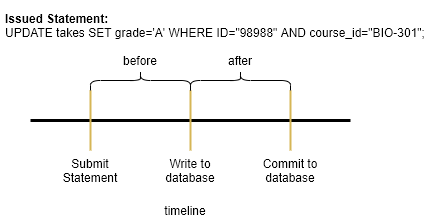

Using the diagram, depending on which trigger time the trigger has, it is executed before or after the write to the database. Nothing is committed until the trigger has successfully executed. This would also apply to triggers that executes multiple times for all rows in a table.

**Properties of Triggers**
* A **major** caveat of Triggers is that it cannot be used to modify a table that is already being used (for reading or writing) by the statement that invoked the trigger.
* can be chained
 
 **Example: Chaining on different tables**<br>
 Assuming that there was no cascade deletion setup on the relationships.
 ```sql
/* Chain 1 */
DELIMITER //
CREATE TRIGGER tDelStu AFTER DELETE ON student
FOR EACH ROW
    BEGIN
        delete FROM takes where ID = OLD.ID;
    END //
DELIMITER ;

 /* Chain 2 */
DELIMITER //
CREATE TRIGGER tDeladvisor AFTER DELETE ON takes
FOR EACH ROW
    BEGIN
        delete FROM advisor where s_ID = OLD.ID;
    END //
DELIMITER ;
 ```

To **remove** a trigger, use the `DROP TRIGGER` statement with the name of the trigger.
```sql
DROP TRIGGER <trigger_name>;
```

### Main differences between Triggers and Stored Procedures

| Characteristics | Triggers | Stored Procedures |
|:---|:---|:---|
| Event driven | Yes | No |
| Associated with a table | Yes | No |
| Return a result | No | Yes |

---
## Database Security

We have briefly talked about database security in the introductory chapters. In this section, we will go further in depth on this topic.

The whole purpose database security for database systems is protect its data against compromising its data (confidentiality & integrity) and availability. As mentioned before, there are 3 types of security models:

* **Authentication** - a process by which you verify that someone is who they claim they are, normally done at organization level. Eg: Are you a staff of the company?
* **Authorization** - the process of establishing if the user (who is already authenticated), is permitted to have access to a resource. Authorization determines what a user is and is not allowed to do.
* **Access Control** - the process of enforcing the required security for a particular resource.

### Authorization & Access Control
When we talk about authorization in databases, we normally refer to the authorization of rights (such as read, insert, update and delete operations) given to the users by the database administrator. These are also called **privileges**. By default, privileges are automatically given by to the user by the DBMS. The database administrator has to use SQL DDL (Data Definition Language) commands to either **grant or revoke** the privileges of the user.

The database administrators generally include performing the following tasks:
* granting privileges to users who need to use the system
* classifying users and data in accordance with the policy of the organization

Let's take a moment to understand what are access rules. Access rules can be broken down into 4 parts:
* **Subject** - which is the user or user group or account
* **Object** - the data (specifically the database or table or attribute or tuple)
* **Rights** - the rights to request DML and DDL (CRUD) operations for the data
* **Predicate** - the conditions under which the user is granted the information

**Example 1 - Understanding access rights implementation**<br>
The following relation
```sql 
employee(eID, eName, age, gender, salary, dID, manager)
```
has different access rights based on different user groups:
* **HR** - will have full access to all information of all employees
* **General Admin** - will only be able to search and read `eName` (employee's name) and `dID` (department ID) of the employee
* **Employee** - will be able to search and read their own records
* **Manager** - will be able to search and read all employees records under their department
* **Senior Manager** - will be able to search and read all employees records

Placing all that information in a table format, we get:

| Subject | Object | Rights | Predicate |
|:---|:---|:---|:---|
| HR | Employee | CRUD | None |
| General Admin | Employee(eName, dID) | Read (inclusive of search) | None |
| Employee | Employee | Read (inclusive of search) | eID = userID |
| Manager | Employee | Read (inclusive of search) | manager = userID |
| Senior Manager | Employee | Read (inclusive of search) | None |

**Example 2 - Listing privileges and objects from SQL statements**
```sql
UPDATE instructor SET salary = salary * 1.1 WHERE ID IN 
    (SELECT ID FROM teaches WHERE course_id="HIS-351");
```

From the above SQL statement, we can produce the following table

| Object | Rights |
|:---|:---|
| instructor.salary | Update |
| instructor.salary | Select |
| instructor.ID | Select |
| teaches.ID | Select |
| teaches.course_id | Select |

Knowing the access rules will help with creating views of the data. <br>
For example, if we were create views for the user groups in example 1, we would have:
```sql
/* for HR - full access is given thus Views are not required */

/* for Senior Manager - where they have read-only access to employee data */
CREATE VIEW seniorMgtView AS SELECT * FROM employee;

/* for General Admin - where they have read-only access to 2 employee attributes */
CREATE VIEW genAdminView AS SELECT eName, dID FROM employee;

/* for Manager - where they have read-only access to employee data of their dept */
CREATE VIEW mgtView AS SELECT * FROM employee WHERE manager=userID;

/* for Employee - where they have read-only access to their own employee data */
CREATE VIEW employeeView AS SELECT * FROM employee WHERE eID=userID;
```

## Exercise

**Qn 1)** Given the following SQL statement list all privileges and objects.
```sql 
DELETE FROM student WHERE ID NOT IN (SELECT ID from takes);
```
**Qn 2)** Given the relation and SQL statement, which privilege is **not required**?
```sql
/* relation */
course(course_id, title, dept_name, credits)

/* SQL statement */
UPDATE course SET credits = 4 WHERE course_id = "EE-181";
```
a) update(credits) <br>
b) read(course_id) <br>
c) read(name) <br>
d) read(credits) <br>

### Answers

**Qn 1)**

| Object | Rights |
|:---|:---|
| student | Delete |
| student.ID | Select (inclusive of read) |
| takes.ID | Select |

**Qn 2)** C

## User Levels/Roles

User levels/roles is the same real world concept of having employee levels within an organization. For example, each manager must
have the same types of authorizations on the same set of relations. Whenever a new manager is appointed, they will have to be given all these authorizations individually.

In terms of the DBMS, the highest authorization level is given to the database administrator followed by the developer that works with the database and lastly the end user.

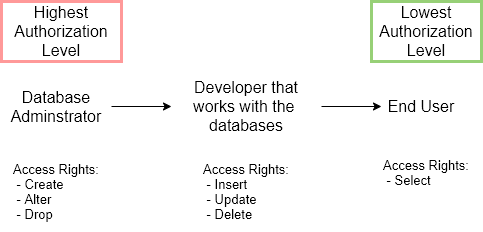

The database administrator would create the user roles and users via the SQL statement:
```sql
/* create role */
CREATE [OR REPLACE] ROLE [IF NOT EXISTS] role 
  [WITH ADMIN {CURRENT_USER | CURRENT_ROLE | user | role}]

/* examples - create role */
CREATE ROLE instructor;
CREATE ROLE developer WITH ADMIN lorinda@localhost;

/* create user */
CREATE USER
  user_name IDENTIFIED BY [ PASSWORD ] 'password_value';

/* example - create user */
CREATE USER 'myuser' IDENTIFIED BY 'mypassword';
```
then each user can have their privileges granted or revoked using the `GRANT` or `REVOKE` SQL statements.

General syntax for `GRANT` & `REVOKE` are
```sql
/* grant */
GRANT {privilege list} [(column_list)]
ON {table/view}
TO {user/role list}
[user_options]

/* grant role to user*/
GRANT role TO grantee [, grantee2 ... ] [ WITH ADMIN OPTION ]

/* revoke */
REVOKE {privilege list}
ON {table/view}
FROM {user/role list}

/* to revoke all privileges */
REVOKE ALL PRIVILEGES, GRANT OPTION FROM user [, user] ...
```
where
* `Privilege List` - has the format `*.*` to denote global privileges
 * `db_name.*` for database privileges
 * `db_name.tbl_name` for table privileges
 * `db_name.routine_name` for function and procedure privileges
* `table` - option of `TABLE`, `FUNCTION` or `PROCEDURE`
* within `user_options` there is an option `GRANT OPTION` that allows the user to grant privileges to other users but the users cannot grant privileges at a higher privilege level than the privileges they were given.

**Example 3**<br>
We will be reusing the relation and information from example 1 and the views created from their access rules

**Relation**
```sql 
employee(eID, eName, age, gender, salary, dID, manager)
```

**Authorization**

| Subject | Object | Rights | Predicate |
|:---|:---|:---|:---|
| HR | Employee | CRUD | None |
| General Admin | Employee(eName, dID) | Read (inclusive of search) | None |
| Employee | Employee | Read (inclusive of search) | eID = userID |
| Manager | Employee | Read (inclusive of search) | manager = userID |
| Senior Manager | Employee | Read (inclusive of search) | None |

**Access rules**
```sql
/* for Senior Manager - where they have read-only access to employee data */
CREATE VIEW seniorMgtView AS SELECT * FROM employee;

/* for General Admin - where they have read-only access to 2 employee attributes */
CREATE VIEW genAdminView AS SELECT eName, dID FROM employee;

/* for Manager - where they have read-only access to employee data of their dept */
CREATE VIEW mgtView AS SELECT * FROM employee WHERE manager=userID;

/* for Employee - where they have read-only access to their own employee data */
CREATE VIEW employeeView AS SELECT * FROM employee WHERE eID=userID;
```

**Employee data**

| Employee Type | eID |
|:---|:---|
| Staff from HR | 2001 |
| Staff from General Admin | 5001 |
| Dept Manager | 1021 |
| Senior Manager | 1001 |

**SQL for granting privileges**
```sql
GRANT ALL ON db_name.* TO 2001;
GRANT SELECT ON db_name.genAdminView  TO 5001;
GRANT SELECT ON db_name.employeeView TO public;
GRANT SELECT ON db_name.mgtView TO 1021;
```

### Granting or Revoking graph

**Grant Process**<br>
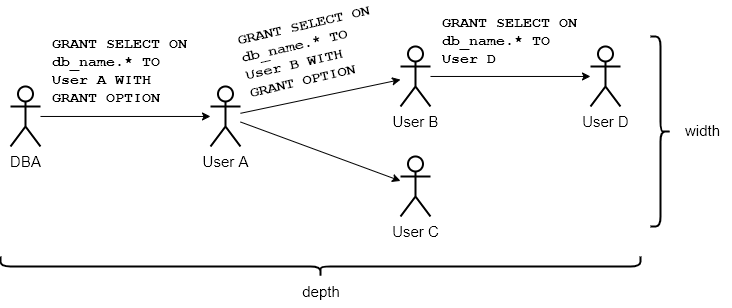

**Revoke Process**<br>
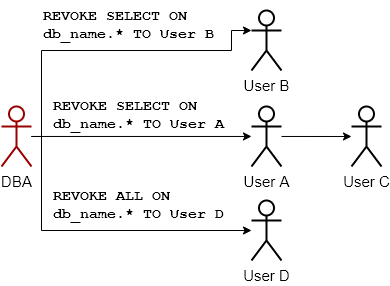

**IMPORTANT NOTE**<br>
For `REVOKE`, MariaDB does not allow options like `CASCADE` or `RESTRICT` because it is not implemented. Revoking is done only on single users or user groups individually.

**Example**<br>
Consider table `R` with owner A. Suppose we have the sequence:<br>
(1) A grants select(R) to B with grant option; <br>
(2) A grants select(R) to C with grant option; <br>
(3) B grants select(R) to D; <br>
(4) C grants select(R) to D; <br>
(5) A revokes select(R) from B. <br>
(6) D issue a `SELECT * FROM R;` statement.
Does step (6) generate an error? (Yes or No)


---
## Summary
* Views
 * how to create them, apply aggregate functions and predicates to the views
 * understanding the conditions under which a view may be updatable
 * deleting a view
* Integrity Constraints
 * different types of constraints (`PRIMARY KEY`, `FOREIGN KEY`, `CHECK`, `UNIQUE`, `NOT NULL`)
 * how to add them during table creation, existing tables and to remove them from tables
 * understand what an index is used for
* Stored Functions and Stored Procedures
 * learnt how to construct, use and remove them
 * the importance of stored procedures
 * the differences between stored functions and stored procedures
* Triggers
 * learnt how to construct, use and remove them
 * learnt about the timing of triggers & properties
 * the differences between triggers and stored procedures
* Database Security
 * learnt about Authorization & Access Control theory
 * creating user and roles
 * learnt how to grant and revoke privileges for users
 * learnt the process of passing on granting and revoke privileges